# NLP and Naive Bayes Modeling:

In this notebook NLP and Naiive Base modeling will be performed on subreddits dataset.

In [389]:
import requests
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [390]:
df = pd.read_csv('data/subreddits.csv')

### Converting python/R to binary labels:

In [391]:
# Create label column for Python and Rlanguage subreddits
df['subreddit'] = df['subreddit'].map({'breakingbad': 0, 'betterCallSaul': 1})

df.drop(columns = 'Unnamed: 0', inplace= True)
df.head()

,subreddit,selftext,title
0,1,"All you people say ""oh boohoo Jimmy, boohoohoo...",Stop denying it. Chuck was right
1,1,We all know that the excavation happened in th...,Where exactly is the excavation project
2,1,Mine is probably Dedicado a Max. It's not horr...,Least favorite episode?
3,1,NaN,Better SUCK Chuck (Official Music Video) pls c...
4,1,NaN,Salamanca Brothers


In [392]:
# Rename Column name
df = df.rename(columns={'selftext': 'post'})
df.isna().sum()

subreddit       0
post         2503
title           0
dtype: int64

In [393]:
# Function to count words in each post:
def word_count(post):
    word_count = 0
    is_in_word = False
    for char in post:
        if char in ' \t\n.!,:;/?\\()"':
            is_in_word = False
        else:
            if not is_in_word:
                word_count += 1
                is_in_word = True

    return (word_count)

In [394]:
# Adding a column showing number of words in each text
df['title_length'] = [word_count(comment) for comment in df['title']]
df.shape

(4993, 4)

In [395]:
df.head()

,subreddit,post,title,title_length
0,1,"All you people say ""oh boohoo Jimmy, boohoohoo...",Stop denying it. Chuck was right,6
1,1,We all know that the excavation happened in th...,Where exactly is the excavation project,6
2,1,Mine is probably Dedicado a Max. It's not horr...,Least favorite episode?,3
3,1,NaN,Better SUCK Chuck (Official Music Video) pls c...,12
4,1,NaN,Salamanca Brothers,2


# NLP

In [396]:
X = df['title']
y = df['subreddit']

In [397]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

## Preprocessing:

#### Countvectorizer

In [398]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [399]:
##### Instantiating:
cvec = CountVectorizer(#tokenizer = '\w+', 
                       stop_words = 'english', 
                       ngram_range = (1,2), 
                       max_features= 3000, 
                       min_df=2, 
                       max_df=.95)

In [400]:
# Fit the data
cvec.fit(X_train)
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)

In [401]:
X_train.shape

(3744, 3000)

In [402]:
# Convert to dataframe
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names())

/Users/ella/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### The top 10 words appeared in the titles:


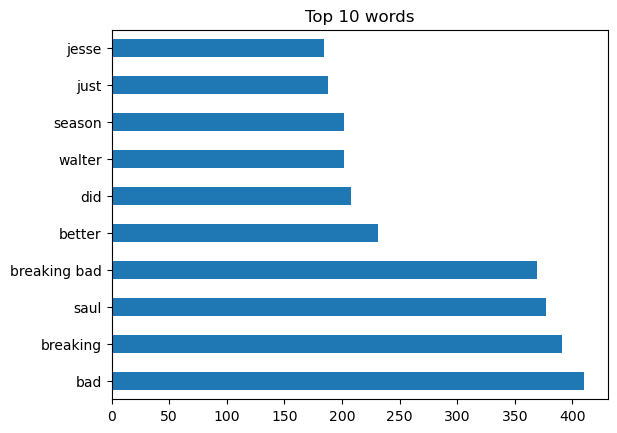

In [403]:
X_train_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')
plt.title('Top 10 words');
plt.savefig('image/top10.png')

#### Baseline Accuracy

In [404]:
y_test.value_counts(normalize = True)

0    0.5004
1    0.4996
Name: subreddit, dtype: float64

## Naive Base Modeling

In [405]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [406]:
pipe = Pipeline([
    ('cvec', CountVectorizer(#tokenizer = '\w+', 
                        stop_words = 'english', 
                       ngram_range = (1,2), max_features= 3000, 
                      min_df=2, max_df=.95)),
    ('nb', MultinomialNB())
])

In [407]:
pipe.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(max_df=0.95, max_features=3000, min_df=2, ngram_range=(1, 2),
                   stop_words='english')),
  ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(max_df=0.95, max_features=3000, min_df=2, ngram_range=(1, 2),
                 stop_words='english'),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 0.95,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__preprocessor': None,
 'cvec__stop_words': 'english',
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [408]:
pipe_params = {
    'cvec__max_features': [1500, 2000, 2500, 3000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.9, .98],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [409]:
gs = GridSearchCV(pipe, # The object we are optimizing
                  param_grid = pipe_params, # The parameters we are searching through
                  cv = 5) # 5-fold cross-validation.

In [410]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(max_df=0.95,
                                                        max_features=3000,
                                                        min_df=2,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.98],
                         'cvec__max_features': [1500, 2000, 2500, 3000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [411]:
# Best Params
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1)}

In [412]:
# Score model on training set.
gs.score(X_train, y_train)

0.8675213675213675

In [413]:
# Score model on testing set.
gs.score(X_test, y_test)

0.7542033626901521

In [414]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/ella/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


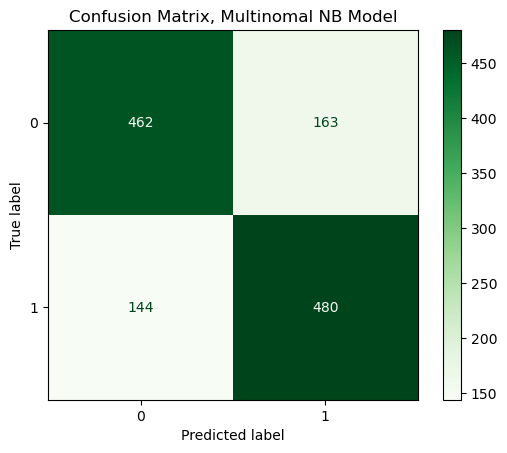

In [415]:
# View confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='Greens', values_format='d')
plt.title('Confusion Matrix, Multinomal NB Model');
plt.savefig('image/nbconfusionm.png')

## Test Accuracy:

In [416]:
accuracy_score(y_test, preds)

0.7542033626901521

In [417]:
# Calculate the specificity
spec = tn / (tn + fp)

print(f'Specificity: {spec}')

Specificity: 0.7392


In [418]:
# Calculate the sensitivity
sens = tp / (fn +tp)

print(f'Sensitivity: {sens}')

Sensitivity: 0.7692307692307693


## TfidfVectorizer

In [419]:
# Split the data into the training and testing sets.
X = df['title']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)
tvec = TfidfVectorizer()
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = 'english', 
                       ngram_range = (1,2), max_features=3000, 
                      min_df=2, max_df=.98)),
    ('nb', MultinomialNB())
])
pipe_tvec.get_params()

/Users/ella/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{'memory': None,
 'steps': [('tvec',
   TfidfVectorizer(max_df=0.98, max_features=3000, min_df=2, ngram_range=(1, 2),
                   stop_words='english')),
  ('nb', MultinomialNB())],
 'verbose': False,
 'tvec': TfidfVectorizer(max_df=0.98, max_features=3000, min_df=2, ngram_range=(1, 2),
                 stop_words='english'),
 'nb': MultinomialNB(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 0.98,
 'tvec__max_features': 3000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': 'english',
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__f

In [420]:
pipe_tvec_params = {
    'tvec__max_features': [1000, 1500, 2000, 3000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)]
}
gs_tvec = GridSearchCV(pipe_tvec,
                      param_grid = pipe_tvec_params,
                      cv = 5)
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(max_df=0.98,
                                                        max_features=3000,
                                                        min_df=2,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [1000, 1500, 2000, 3000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [421]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.8720619658119658

In [422]:
gs_tvec.score(X_test, y_test)

0.7429943955164131

In [423]:
# Best params?
gs_tvec.best_params_

{'tvec__max_features': 3000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [424]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# Calculate the specificity

spec = tn / (tn + fp)

print(f'Specificity: {spec}')

Specificity: 0.7248


/Users/ella/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


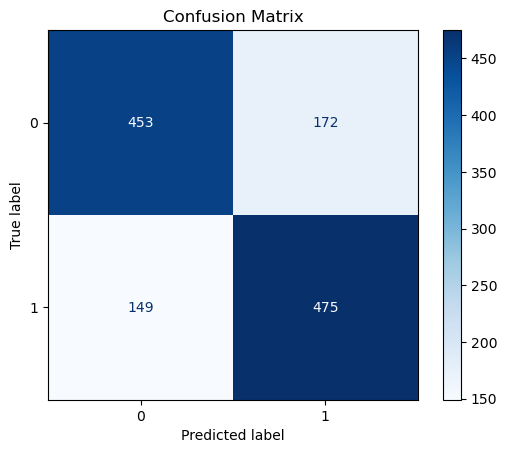

In [425]:
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap = 'Blues'),
plt.title('Confusion Matrix');

## Test Accuracy

In [426]:
accuracy_score(y_test, preds)

0.7542033626901521